In [ ]:
#Classification task

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.utils.data as Data
import torch
from torchvision import models
from torchsummary import summary
import torchvision

In [3]:
class CNN(nn.Module):
   
    def __init__(self, n_channels, pdrop2d, pdrop1d):
     # img size = 28x28
        super(CNN, self).__init__()
    
        self.conv1 = nn.Conv2d(1, n_channels, kernel_size=3, padding=1)
        self.mpool = nn.MaxPool2d(2, 2) 
        # Max Pooling --> img size halved = 14x14
        self.drop2 = nn.Dropout2d(p=pdrop2d) 
        # dropout layer
        self.conv2 = nn.Conv2d(n_channels, 2*n_channels, kernel_size=5) 
        # fully connceted layer with (img size)x(2*n_channels)=50xn_channels, 100 output units
        self.fulc1 = nn.Linear(50*n_channels, 100)
        # dropout after first linear layer
        self.drop1 = nn.Dropout(p=pdrop1d)
        # fully connected layer with inputs equal to number of outputs of previous layer, 10 outputs (10 digits)
        self.fulc2 = nn.Linear(100, 10)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.mpool(x)
        x = F.relu(self.conv2(x))
        x = self.mpool(x)
        x = self.drop2(x)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fulc1(x))
        x = self.drop1(x)
        x = self.fulc2(x)
        
        return x
    
    def train_step(self, train_loader, optimizer, loss_func, device, epoch, verbose=False):
        #initialize vector containing training losses
        train_loss = [] 
        self.train()    
        for ii, s_batch in enumerate(train_loader):
            #import data, move to device
            x_batch = s_batch[0].to(device)       
            label_b = s_batch[1].to(device)   
            #forward pass
            for_out = self.forward(x_batch)       
            tr_loss = loss_func(for_out, label_b) 
            #back-propagation
            self.zero_grad()                      
            tr_loss.backward()
            optimizer.step()                      
            ba_loss = tr_loss.detach().cpu().numpy()
            train_loss.append(ba_loss)           
        return train_loss
    
    
    def val_step(self, valid_loader, loss_func, device):
        #initialize vector containing validation losses
        val_loss = [] 
        self.eval()   
        with torch.no_grad():                         
            for s_batch in valid_loader:
                
                x_batch = s_batch[0].to(device)  
                #import labels, move to device
                label_b = s_batch[1].to(device)       
                for_out = self.forward(x_batch)       
                va_loss = loss_func(for_out, label_b) 
                ba_loss = va_loss.detach().cpu().numpy()
                val_loss.append(ba_loss)           
        return val_loss
    
    def fitting(self, train_loader, val_loader, optimizer, loss_func, verbose, param):

        train_loss_log = [] 
        val_loss_log = []
        # Training
        for epoch in tqdm(range(param['num_epochs'])):
            train_loss = self.train_step(train_loader, optimizer, loss_func, 
                                         param['device'], epoch, verbose)
            # Compute and store average training loss
            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)
            valid_loss = self.val_step(val_loader, loss_func, param['device'])
            valid_loss = np.mean(valid_loss)
            val_loss_log.append(valid_loss)
            # Check for early stopping condition
            stop = self._early_stopping(val_loss_log, param['num_epochs'])
            if stop: 
                print('Early stopping at epoch ', epoch)
                param['num_epochs'] = epoch
                break
            
        return train_loss_log, val_loss_log
    
    def predicting(self, data_loader, device):
        #initialize vector containing predictions
        predicts = [] 
        self.eval()  
        #disable gradient tracking
        with torch.no_grad():                   
            for s_batch in tqdm(data_loader):
                
                x_batch = s_batch[0].to(device) 
                
                for_out = self.forward(x_batch) 
                outputs = for_out.cpu().numpy().argmax()
                predicts.append(outputs)        
        return np.array(predicts)
                    
    def _early_stopping(self, val_loss_log, num_epochs):
        
        stop = False
        
        if len(val_loss_log)>1:
            # set interval dimension in which to check loss values
            range_loss = min(len(val_loss_log), 10)
            last_loss = val_loss_log[-1]
            mean_loss = np.mean(val_loss_log[-range_loss:-1])
            
            if (np.abs(last_loss-mean_loss) < 0.005): 
                stop = True
                
        return stop


In [4]:
#dataset import and download
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

SAMPLE AT INDEX 0
LABEL: 9


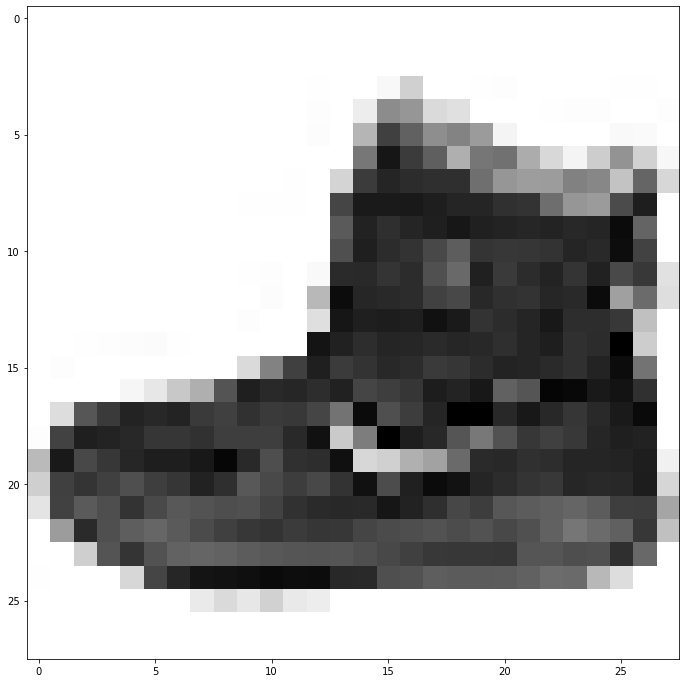

In [9]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(12,12))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [10]:
image=np.array(image)
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

In [11]:
composed_transforms = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))] )

train_dataset_full = torchvision.datasets.FashionMNIST('classifier_data', train=True, 
                                                download=True, transform=composed_transforms)
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, 
                                                download=True, transform=composed_transforms)

In [12]:
# Initial parameters
n_epochs = 15
batch_size_train = 16
batch_size_test = 500
learning_rate = 0.0005
momentum = 0.95
# prepare validation set by splitting the train set
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset_full, [int(0.8*len(train_dataset_full)),int(0.2*len(train_dataset_full))])
train_load = Data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_load = Data.DataLoader(valid_dataset, batch_size=batch_size_train, shuffle=False)
test_load  = Data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)


In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

params_dict = {"device"        : [device],
               "num_epochs"    : [n_epochs],
               "n_channels"    : [6, 8, 12], 
               "pdrop1d"       : [0.01, 0.05, 0.1],
               "pdrop2d"       : [0.01, 0.05],
               "optimizer"     : ['sgd', 'adam'],
               "momentum"      : [0.5, 0.7, 0.9],
               "learning_rate" : [0.0001, 0.0005, 0.001],
               "reg_param"     : [0.0001,0.0003, 0.0005],
                }

In [14]:
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

def random_search(par_dict, train_loader, valid_loader, n_models):
    
    # initialise outputs
    model_params = []
    train_loss_log = []
    val_loss_log = []

    for i in tqdm(range(n_models)):
        
        # select random parameters
        params = random_params(par_dict)
        
        print('Model ', i+1)
        print('Network parameters:', params)
        
        # initialize network
        model = CNN(params['n_channels'], params['pdrop2d'], params['pdrop1d'] )
        model.to(params['device'])
        
        # initialize loss function
        loss_func = nn.CrossEntropyLoss() 
        # set up optimizer
        if params['optimizer']=='adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                             weight_decay=params['reg_param'])
        elif params['optimizer']=='sgd':
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], 
                            momentum=params['momentum'], weight_decay=params['reg_param'])
        
        # training & validation process
        train_loss, valid_loss = model.fitting(train_loader, valid_loader, optimizer, 
                                             loss_func,verbose, params)
        
        train_loss_log.append(train_loss)
        val_loss_log.append(valid_loss)
        
        # append final to parameter dictionnary  final loss for each model studied
        params['final_loss'] = valid_loss[-1]
        model_params.append(params)
        
    return model_params, train_loss_log, val_loss_log
def testing(network, test_loader, loss_func, device):

    network.eval()  
    corrects  = 0.
    totals    = 0.
    test_loss = 0.
    
    with torch.no_grad():
        for s_batch in test_loader:
            
            x_batch = s_batch[0].to(device)       
            label_b = s_batch[1].to(device)       
            outputs = network(x_batch)
            
            test_loss += loss_func(outputs, label_b).item()
            
            _, predicted = torch.max(outputs.data, 1)
            totals += label_b.size(0)
            corrects += (predicted == label_b).sum().item()
        
        accuracy = (corrects / totals) * 100
        avg_test_loss = test_loss / totals
        
        print("Average test loss:",avg_test_loss, "\n Accuracy:",accuracy)
           
    return avg_test_loss, accuracy

In [16]:
verbose=True
model_params, train_loss_rs, valid_loss_rs = random_search(params_dict, train_load, valid_load, 15)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Model  1
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.1, 'pdrop2d': 0.01, 'optimizer': 'sgd', 'momentum': 0.7, 'learning_rate': 0.0001, 'reg_param': 0.0001}



  7%|█████▎                                                                         | 1/15 [34:40<8:05:29, 2080.66s/it]

Model  2
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.1, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.5, 'learning_rate': 0.0001, 'reg_param': 0.0001}



 13%|██████████▎                                                                  | 2/15 [1:16:09<8:22:49, 2320.75s/it]

Model  3
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 8, 'pdrop1d': 0.05, 'pdrop2d': 0.05, 'optimizer': 'sgd', 'momentum': 0.9, 'learning_rate': 0.001, 'reg_param': 0.0005}



 20%|███████████████▍                                                             | 3/15 [2:00:25<8:14:48, 2474.05s/it]

Model  4
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 12, 'pdrop1d': 0.05, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.5, 'learning_rate': 0.0001, 'reg_param': 0.0003}



 27%|████████████████████▌                                                        | 4/15 [2:57:18<8:41:31, 2844.70s/it]

Model  5
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 8, 'pdrop1d': 0.1, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.7, 'learning_rate': 0.001, 'reg_param': 0.0003}



 33%|█████████████████████████▋                                                   | 5/15 [3:51:48<8:19:39, 2997.94s/it]

Model  6
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.1, 'pdrop2d': 0.01, 'optimizer': 'adam', 'momentum': 0.7, 'learning_rate': 0.0005, 'reg_param': 0.0001}



 40%|██████████████████████████████▊                                              | 6/15 [4:41:54<7:30:05, 3000.66s/it]

Model  7
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 8, 'pdrop1d': 0.01, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.9, 'learning_rate': 0.0005, 'reg_param': 0.0005}



 47%|███████████████████████████████████▉                                         | 7/15 [5:31:36<6:39:16, 2994.53s/it]

Model  8
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 12, 'pdrop1d': 0.1, 'pdrop2d': 0.01, 'optimizer': 'sgd', 'momentum': 0.7, 'learning_rate': 0.0001, 'reg_param': 0.0005}



 53%|█████████████████████████████████████████                                    | 8/15 [6:19:29<5:44:52, 2956.03s/it]

Model  9
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 12, 'pdrop1d': 0.01, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.9, 'learning_rate': 0.0005, 'reg_param': 0.0003}



 60%|██████████████████████████████████████████████▏                              | 9/15 [7:17:03<5:11:08, 3111.42s/it]

Model  10
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.01, 'pdrop2d': 0.01, 'optimizer': 'sgd', 'momentum': 0.9, 'learning_rate': 0.0005, 'reg_param': 0.0001}



 67%|██████████████████████████████████████████████████▋                         | 10/15 [7:58:40<4:03:29, 2921.89s/it]

Model  11
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 12, 'pdrop1d': 0.01, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.9, 'learning_rate': 0.0001, 'reg_param': 0.0001}



 73%|█████████████████████████████████████████████████████▌                   | 11/15 [21:44:37<19:06:18, 17194.74s/it]

Model  12
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.05, 'pdrop2d': 0.01, 'optimizer': 'sgd', 'momentum': 0.9, 'learning_rate': 0.001, 'reg_param': 0.0003}



 80%|██████████████████████████████████████████████████████████▍              | 12/15 [22:19:47<10:30:16, 12605.57s/it]

Model  13
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.05, 'pdrop2d': 0.01, 'optimizer': 'sgd', 'momentum': 0.7, 'learning_rate': 0.0005, 'reg_param': 0.0003}



 87%|█████████████████████████████████████████████████████████████████          | 13/15 [22:54:24<5:13:52, 9416.17s/it]

Model  14
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 8, 'pdrop1d': 0.01, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.9, 'learning_rate': 0.001, 'reg_param': 0.0001}



 93%|██████████████████████████████████████████████████████████████████████     | 14/15 [23:27:33<1:59:32, 7172.76s/it]

Early stopping at epoch  11
Model  15
Network parameters: {'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 12, 'pdrop1d': 0.05, 'pdrop2d': 0.01, 'optimizer': 'sgd', 'momentum': 0.9, 'learning_rate': 0.0001, 'reg_param': 0.0001}



100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [24:07:38<00:00, 5790.55s/it]


In [17]:
avg_val_loss = [np.mean(vl) for vl in valid_loss_rs]
best_model = model_params[np.argmin(avg_val_loss)]
print(best_model)

{'device': device(type='cpu'), 'num_epochs': 15, 'n_channels': 12, 'pdrop1d': 0.01, 'pdrop2d': 0.05, 'optimizer': 'adam', 'momentum': 0.9, 'learning_rate': 0.0005, 'reg_param': 0.0003, 'final_loss': 0.2560522}


In [19]:
#Best networks testing
# use full train set to train, test set to validate model
train_load_full = Data.DataLoader(train_dataset_full, batch_size=batch_size_train, shuffle=True)
final_model = CNN(int(best_model['n_channels']), best_model['pdrop2d'], best_model['pdrop1d'] )
final_model.to(device)
loss_func = nn.CrossEntropyLoss() 

if best_model['optimizer']=='adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_model['learning_rate'], 
                     weight_decay=best_model['reg_param'])
elif best_model['optimizer']=='sgd':
    optimizer = optim.SGD(final_model.parameters(), lr=best_model['learning_rate'], 
                    momentum=best_model['momentum'], weight_decay=best_model['reg_param'])
    
best_model['num_epochs'] = 15
best_model['device'] = device
verbose = True 

# Training and testing
best_train_loss, best_test_loss = final_model.fitting(train_load_full, test_load, optimizer,
                                                    loss_func, verbose, best_model)


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [51:01<12:45, 255.09s/it]

Early stopping at epoch  12


<Figure size 432x288 with 0 Axes>

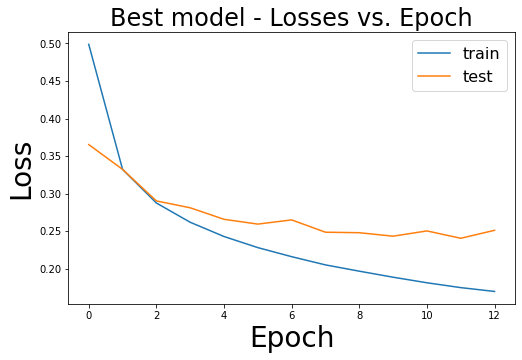

In [20]:
# Plot training results
plt.clf()
fig, ax = plt.subplots(figsize=(8,5))

ax.set_xlabel('Epoch', fontsize=28)
ax.set_ylabel('Loss', fontsize=28)


ax.set_title('Best model - Losses vs. Epoch', fontsize=24)
ax.plot(best_train_loss, label='train')
ax.plot(best_test_loss, label='test')
ax.legend(loc='best', fontsize=16)

plt.savefig('MNIST_tr_test_loss_BEST.png')
plt.show()

In [21]:
# store best parameters
model_state_dict = final_model.state_dict()
torch.save(model_state_dict, 'FashionMNIST_best_model_parameters.torch')
torch.save(optimizer.state_dict(), 'FashionMNIST_optimizer_state.torch')

In [22]:
final_avg_test_loss, accuracy = testing(final_model, test_load, loss_func, device)

Average test loss: 0.0005026173576712608 
 Accuracy: 91.36


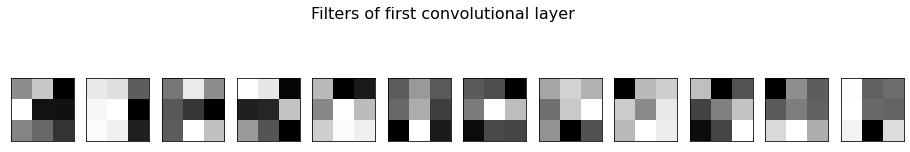

In [23]:
#Weight Analysis
# First Convolutional layer
conv1_w = final_model.conv1.weight.data.cpu().numpy()
conv1_b = final_model.conv1.bias.data.cpu().numpy()
# Second Convolutional layer
conv2_w = final_model.conv2.weight.data.cpu().numpy()
conv2_b = final_model.conv2.bias.data.cpu().numpy()

fig, ax = plt.subplots(1,int(best_model['n_channels']), figsize=(16, 3))
for i in range(int(best_model['n_channels'])):
    ax[i].imshow( conv1_w[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters of first convolutional layer', fontsize=16)
plt.savefig('filters_CONV1.png')
plt.show()

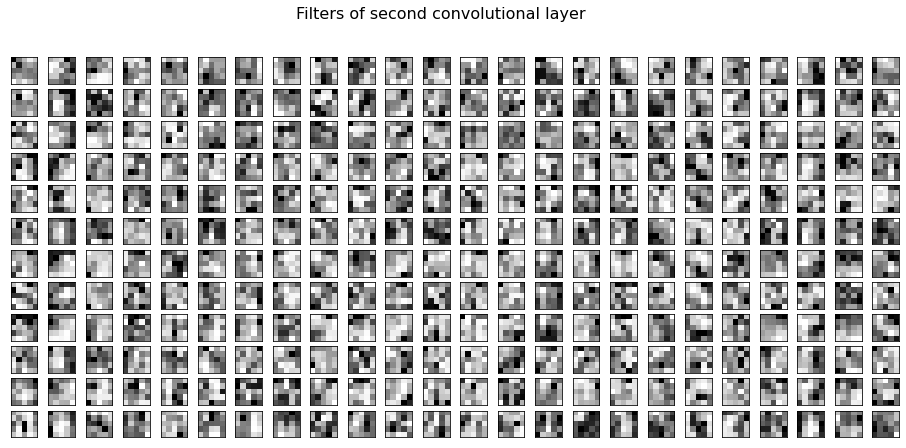

In [24]:
# Filters of first convolutional layer
fig, ax = plt.subplots(int(best_model['n_channels']), 2*int(best_model['n_channels']), figsize=(16, 7))
for i in range(int(best_model['n_channels'])):
    for j in range(2*int(best_model['n_channels'])):
        ax[i,j].imshow( conv2_w[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
fig.suptitle('Filters of second convolutional layer', fontsize=16)
plt.savefig('filters_CONV2.png')
plt.show()

In [25]:
# Activations Analysis 
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook
handle_hook_conv1 = final_model.conv1.register_forward_hook(get_activation('conv1'))
handle_hook_conv2 = final_model.conv2.register_forward_hook(get_activation('conv2'))

image_load = DataLoader(test_dataset, batch_size=1, shuffle=False) 
final_model = final_model.to(device)
final_model.eval()

with torch.no_grad():
    for s_batch in image_load:
        x = s_batch[0].to(device)
        y = final_model(x)
    
activation_conv1 = activation['conv1'].cpu().numpy()
activation_conv2 = activation['conv2'].cpu().numpy()
# Remove hook
handle_hook_conv1.remove()
handle_hook_conv2.remove()

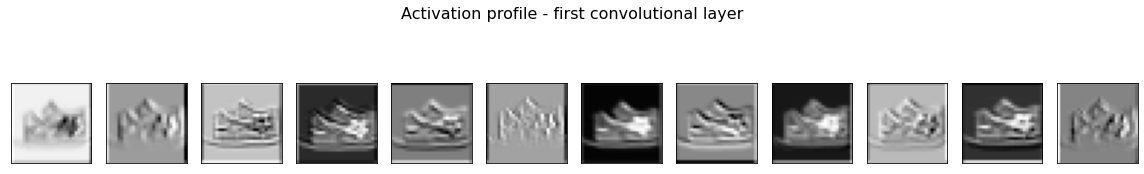

In [26]:
fig, ax = plt.subplots(1, int(best_model['n_channels']), figsize=(16,3))
for i in range(int(best_model['n_channels'])):
    ax[i].imshow( activation_conv1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Activation profile - first convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_CONV1.png')
plt.show()   

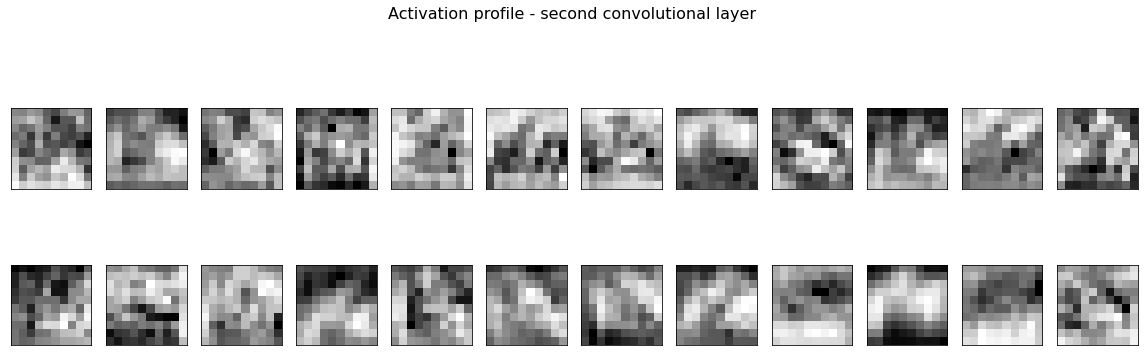

In [27]:
fig, ax = plt.subplots(2, int(best_model['n_channels']), figsize=(16,6))

for i in range(int(best_model['n_channels'])):
    ax[0, i].imshow( activation_conv2[0, i, :, :], cmap='Greys')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow( activation_conv2[0, i+int(best_model['n_channels']), :, :], cmap='Greys')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

fig.suptitle('Activation profile - second convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_CONV2.png')
plt.show()   